In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
from dataloaders import DemoDataset
from utils import read_json

ModuleNotFoundError: No module named 'dataloaders'

In [2]:
# setup dataloader instances
cfg = read_json("config.json")
dataset_cfg = cfg["dataset"]
dataloader_cfg = cfg["dataloader"]
test_cfg = cfg["test"]
dataset_cfg["params"]["fnames"] = ["recording_0002_2020_12_3.h5"]
# dataset_cfg["params"]["fnames"] = ["recording_0003_2020_12_3.h5"]
dataset_cfg["params"]["contact_only"] = False

dataset = DemoDataset(**dataset_cfg["params"])

dataset start time 0.5355069637298584, end time 13.734471321105957
there are 1320 samples


In [3]:
force_x = dataset.all_states_force[:, 0]
force_y = dataset.all_states_force[:, 1]
force_z = dataset.all_states_force[:, 2]

time = dataset.all_states_time

### Offset correction for each axis

choose first x indices as start phase of the robot, pick the force in this period as baseline.

In [4]:
start_period = 10  # choose the first 10 data point
baseline_x = np.mean(force_x[:start_period])
baseline_y = np.mean(force_y[:start_period])
baseline_z = np.mean(force_z[:start_period])

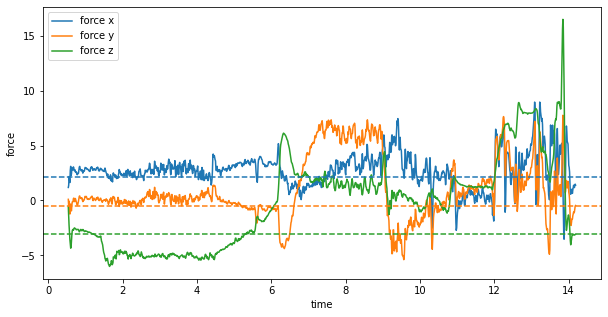

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time, force_x, label='force x')
ax.plot(time, force_y, label='force y')
ax.plot(time, force_z, label='force z')

ax.axhline(baseline_x, color='tab:blue', linestyle='--')
ax.axhline(baseline_y, color='tab:orange', linestyle='--')
ax.axhline(baseline_z, color='tab:green', linestyle='--')

ax.set_xlabel("time")
ax.set_ylabel("force")

ax.legend(loc='upper left')
plt.show()

minus offset

In [6]:
force_x = force_x - baseline_x
force_y = force_y - baseline_y
force_z = force_z - baseline_z

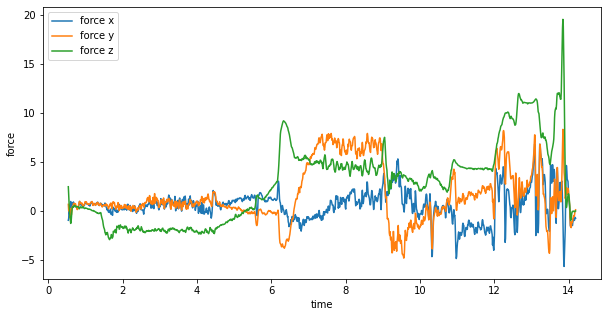

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time, force_x, label='force x')
ax.plot(time, force_y, label='force y')
ax.plot(time, force_z, label='force z')

ax.set_xlabel("time")
ax.set_ylabel("force")
ax.legend(loc='upper left')
plt.show()

In [8]:
force_xyz = dataset._calibrate_force(dataset.all_states_force)

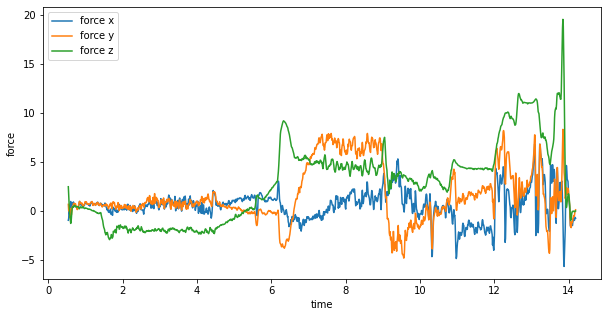

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time, force_xyz[:,0], label='force x')
ax.plot(time, force_xyz[:,1], label='force y')
ax.plot(time, force_xyz[:,2], label='force z')

ax.set_xlabel("time")
ax.set_ylabel("force")
ax.legend(loc='upper left')
plt.show()

### Reduce force x, y, z to 1d via magnitude

In [11]:
all_force = np.vstack((force_x, force_y, force_z)).T

In [12]:
sigma = 8

mag_xyz = np.linalg(all_force, axis=1)
mag_lp = gaussian_filter1d(mag_xyz, sigma=sigma)

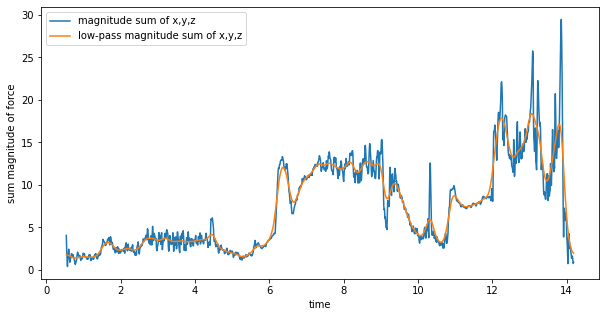

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dataset.all_states_time, mag_xyz, label="magnitude sum of x,y,z")
ax.plot(dataset.all_states_time, mag_lp, label="low-pass magnitude sum of x,y,z")

ax.set_xlabel("time")
ax.set_ylabel("sum magnitude of force")

ax.legend() 
plt.show()

### Energy (square)

In [14]:
# straightforward, compute the energy globally
energy = mag_xyz ** 2
energy_norm = energy / np.amax(energy)  # normalized

# local energy, like low pass
energy_lp = mag_lp ** 2
energy_lp_norm = energy_lp / np.amax(energy_lp)  # normalized

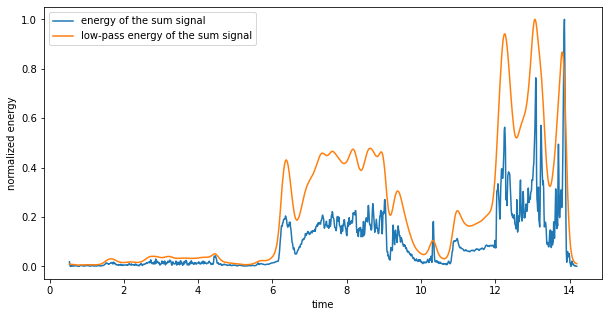

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dataset.all_states_time, energy_norm, label="energy of the sum signal")
ax.plot(dataset.all_states_time, energy_lp_norm, label="low-pass energy of the sum signal")

ax.set_xlabel("time")
ax.set_ylabel("normalized energy")

ax.legend()
plt.show()

### Discrete Derivative 

In [16]:
energy_diff = np.diff(energy_lp_norm)  # energy difference
time_diff = np.diff(time)  # time difference

# derivative = energy_diff / time_diff
energy_derivative = energy_diff/ time_diff
energy_derivative = np.append(energy_derivative, 0.0)

# choose local energy diff for novelty here
novelty = np.copy(energy_derivative)

# normalize to [-1, 1]
novelty /= np.amax(abs(novelty))

In [17]:
energy_thres = .1
novelty_thres = .1

# start point should be small, and have large positive novelty
start_mask = (novelty >= novelty_thres) & (energy_lp_norm <= energy_thres)
start_candidate = np.where(start_mask)[0]

# end point should also be small, and have large negative novelty
end_mask = (novelty <= -novelty_thres) & (energy_lp_norm <= energy_thres)
end_candidate = np.where(end_mask)[0]

# if the last energy is not small
# it could be also an end point (sudden stop of recording
if energy_lp_norm[-1] >= energy_thres:
    end_candidate = np.append(end_candidate, time.size - 1) 

In [18]:
def find_start_bounds(candidate, tolerant=10):
    """
    find start boundaries, keep the first found bound
    """
    bounds = [candidate[0]]
    bound_prev = bounds[0]

    for idx in range(candidate.size):
        bound_new = candidate[idx]

        if bound_new - bound_prev >= tolerant:
            bounds.append(bound_new)

        bound_prev = bound_new
    return np.array(bounds)


def find_end_bounds(candidate, tolerant=10):
    """
    find end boundary, keep the last fined bound
    """
    bounds = [candidate[0]]

    for idx in range(candidate.size):
        bound_new = candidate[idx]

        if bound_new - bounds[-1] >= tolerant:
            bounds.append(bound_new)
        else:
            bounds[-1] = bound_new
    return np.array(bounds)


def match_pair(start, end):
    """
    match the first found start and the last found end
    """
    return [start[0]], [end[-1]]


# def match_pair(start, end):
#     """
#     for the corresponding start point for given end points
#     """
#     start_new = []

#     for e in end:
#         diff = e - start
#         min_idx = np.sum(diff > 0) - 1
#         start_new.append(start[min_idx])

#     return np.array(start_new), end

In [19]:
start = find_start_bounds(start_candidate)
end = find_end_bounds(end_candidate)

start, end = match_pair(start, end)

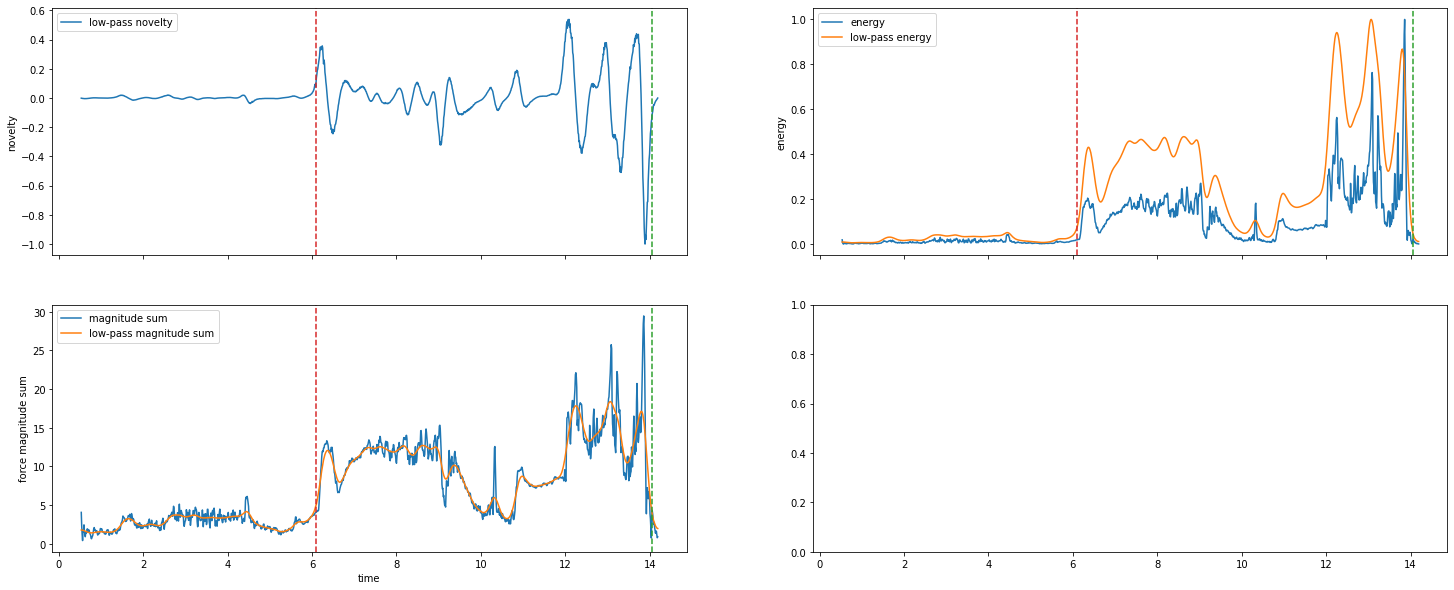

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(25, 10), sharex='all')

axs[0, 0].plot(time, novelty, label="low-pass novelty")
axs[0, 0].set_ylabel("novelty")
axs[0, 0].legend()
for s in start:
    axs[0, 0].axvline(x=time[s], color='tab:red', linestyle='--')
for e in end:
    axs[0, 0].axvline(x=time[e], color='tab:green', linestyle='--')

axs[0, 1].plot(time, energy_norm, label="energy")
axs[0, 1].plot(time, energy_lp_norm, label="low-pass energy")
axs[0, 1].set_ylabel("energy")
axs[0, 1].legend()
for s in start:
    axs[0, 1].axvline(x=time[s], color='tab:red', linestyle='--')
for e in end:
    axs[0, 1].axvline(x=time[e], color='tab:green', linestyle='--')

axs[1, 0].plot(time, mag_xyz, label="magnitude sum")
axs[1, 0].plot(time, mag_lp, label="low-pass magnitude sum")
axs[1, 0].set_xlabel("time")
axs[1, 0].set_ylabel("force magnitude sum")
axs[1, 0].legend()
for s in start:
    axs[1, 0].axvline(x=time[s], color='tab:red', linestyle='--')
for e in end:
    axs[1, 0].axvline(x=time[e], color='tab:green', linestyle='--')

ax.legend()
plt.show()